In [1]:
import pandas as pd
import numpy as np
import copy
import random
from math import sqrt
import scipy.stats as sts

from tqdm import tqdm_notebook

from supplement_package import game
from supplement_package import variables_pecan

pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

In [3]:
from supplement_package.game.stackelberg import StackelbergPlayer

In [4]:
import gurobipy as gp

from supplement_package.gurobi_implementation.gurobi import GurobiSolution

## Data preliminaries 

In [7]:
agent_keys = [661, 1642, 2335, 2361, 2818, 3039, 3456, 3538, 4031, 4373, 4767, 5746, 6139, 7536, 7719, 7800, 7901, 7951, 8156, 8386, 8565, 9019, 9160, 9922, 9278]

dataframe_dict = dict()
for key in agent_keys:
    dataframe_dict.update({key : pd.read_csv('/Users/ishilov/Documents/risk_paper/risk_paper/data/df_{}.csv'.format(key))})

community_size = len(dataframe_dict)

for key in agent_keys:
    cond_min = (dataframe_dict[key]['demand'].quantile(0.01) <= dataframe_dict[key]['demand'])
    cond_max = (dataframe_dict[key]['demand'] <= dataframe_dict[key]['demand'].quantile(0.99))
    dataframe_dict[key] = dataframe_dict[key][cond_min & cond_max]

In [8]:
def generate_new_params(sample_size, community_size):
    res = {}

    for sample in range(sample_size):
        A_tilde = [random.uniform(0,1) for i in range(community_size)]
        B_tilde = [random.uniform(0,1) for i in range(community_size)]

        a = [random.uniform(0,1) for i in range(community_size)]
        b = [random.uniform(0,1) for i in range(community_size)]
        d = [random.uniform(0,1) for i in range(community_size)]

        #d_target = [[random.uniform(0,8) for j in range(len(probabilities))] for i in range(community_size)]
        #g_res = [[random.uniform(0,3) for j in range(len(probabilities))] for i in range(community_size)]

        #g_res = np.array(g_res)
        #d_target = np.array(d_target)

        risk_aversion = [random.uniform(0,1) for i in range(community_size)]

        res.update({sample : {'A_tilde' : A_tilde,
                        'B_tilde' : B_tilde,
                        'a' : a,
                        'b' : b,
                        'd' : d,
                        'risk_aversion' : risk_aversion}})

    res_reformed = {(i, key) : res[i][key] for i in range(sample_size) for key in res[0].keys()}
    mindx = pd.MultiIndex.from_tuples(res_reformed.keys())
    df = pd.DataFrame(list(res_reformed.values()), index = mindx)
    df.to_csv(f'../data/param_{sample_size}.csv')


In [9]:
def text_to_adj_matrix(matrix_path):
    res = []
    with open(matrix_path) as file:
        for s in file:
            string = ''.join(s.strip().strip(',').split(', '))
            lst_temp = [int(sym) for sym in string]

            res.append(lst_temp)

    return res

In [10]:
#generate_new_params(2000)

In [11]:
def read_df_param(sample_size):
    df_param = pd.read_csv(f'../data/param_{sample_size}.csv')
    df_param.rename({'Unnamed: 0' : 'Sample', 'Unnamed: 1' : 'Parameter'}, axis=1, inplace= True)
    df_param.set_index(['Sample', 'Parameter'], inplace=True)

    return df_param

In [12]:
def distribution_build(sample_size, agent_keys):
    res = {}
    
    for key in agent_keys:
        #chunks_demand = int(demand_dict[key][0].size / sample_size)
        #chunks_generation = int(solar_dict[key][0].size / sample_size)


        #probas_demand = [np.trapz(demand_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            demand_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_demand)]

        #probas_generation = [np.trapz(generation_dict[key][1][i * sample_size : (i + 1) * sample_size],
        #                            generation_dict[key][0][i * sample_size : (i + 1) * sample_size])
        #                            for i in range(chunks_generation)]

        #res_demand = plt.hist(np.random.choice(demand_dict[key][0], size = sample_size, p = probabilities), bins = int(sample_size / 2))
        #probas_update = res_demand[0] / res_demand[0].sum() if key == 661 else res[661]['probabilities']
        #res.update({key : 
        #            {'values' : res_demand[1], 
        #            'probabilities' : probas_update}})

        hist_demand = plt.hist(dataframe_dict[key]['demand'], bins = sample_size)
        probas_demand, values_demand = hist_demand[0], hist_demand[1]
        probas_demand = probas_demand / probas_demand.sum()

        if 'solar' in dataframe_dict[key].columns:
            hist_solar = plt.hist(dataframe_dict[key][dataframe_dict[key]['solar'] >= 0]['solar'], bins = sample_size)
            probas_solar , values_solar  = hist_solar[0], hist_solar[1]
            probas_solar = probas_demand / probas_demand.sum()

        res.update({key : 
                    {'probas_demand' : probas_demand,
                    'values_demand' : values_demand,
                    'probas_solar' : probas_solar,
                    'values_solar' : values_solar}})

    return res 

In [13]:
def scenario_sampling(sample_size, agent_keys, main_key = 661):
    distribution = distribution_build(sample_size, agent_keys)

    probabilities = distribution[main_key]['probas_demand']

    d_target = []
    g_res = []
    for key in agent_keys:
        d_target.append(distribution[key]['values_demand'][:-1])
        g_res.append(distribution[key]['values_solar'][:-1])

    return probabilities, d_target, g_res

In [14]:
def param_input(df, index = 0):
    A_tilde = list(df.loc[index].loc['A_tilde'])
    B_tilde = list(df.loc[index].loc['B_tilde'])
    a = list(df.loc[index].loc['a'])
    b = list(df.loc[index].loc['b'])
    d = list(df.loc[index].loc['d'])
    risk_aversion = list(df.loc[index].loc['risk_aversion'])

    return A_tilde, B_tilde, a, b, d, risk_aversion

In [15]:
param_amount = 2000

#generate_new_params(param_amount,community_size=community_size)
df_param = read_df_param(param_amount)

In [16]:
def sample_to_csv(scenario_amount, probabilities, d_target, g_res):
    pd.DataFrame(d_target).to_csv(f'../data/df_d_target_{scenario_amount}.csv')
    pd.DataFrame(g_res).to_csv(f'../data/df_g_res_{scenario_amount}.csv')
    pd.DataFrame(probabilities).to_csv(f'../data/df_probabilities_{scenario_amount}.csv')

In [17]:
def sample_from_csv(scenario_amount):
    df_d_target = pd.read_csv(f'../data/df_d_target_{scenario_amount}.csv').drop('Unnamed: 0', axis = 1)
    df_g_res = pd.read_csv(f'../data/df_g_res_{scenario_amount}.csv').drop('Unnamed: 0', axis = 1)
    df_probabilities =pd.read_csv('../data/df_probabilities_100.csv').drop('Unnamed: 0', axis = 1)
    
    probabilities = df_probabilities.values.squeeze()


    d_target = []
    for _, row in df_d_target.iterrows():
        d_target.append(row.values)

    g_res = []
    for _, row in df_g_res.iterrows():
        g_res.append(row.values)

    return probabilities, d_target, g_res
    

In [18]:
probabilities, d_target, g_res = sample_from_csv(100)
A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param)

In [20]:
def agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res):
    agents = []
    StackelbergPlayer.community_size = community_size
    StackelbergPlayer.probabilities = probabilities

    epsilon = 0.001
    alpha = [[proba/(1 - min(risk_aversion)) for proba in probabilities] for i in range(community_size)]
    #alpha = [[0.2 for proba in probabilities] for i in range(community_size)]
    gamma = [100000 for proba in probabilities]

    j_max = [10 for i in range(community_size)]

    for i in range(community_size):
        agent = StackelbergPlayer(i, d_target[i], g_res[i], a[i], b[i], d[i], 
                    A_tilde[i], B_tilde[i], D_min[i], D_max[i], 
                    G_min[i], G_max[i], risk_aversion[i], Kappa[i], Cost[i], connection_matrix[i],
                    probabilities = probabilities,
                    alpha = alpha[i], 
                    gamma = gamma, 
                    insurance_bound=j_max[i])
        
        agents.append(agent)

    return agents

In [29]:
def vars_to_dict(model, list_vars):
    var_names = []
    
    for var in model.getVars():
        var_names.append(var.VarName)

    dict_res = {}
    for name, var in zip(var_names, list_vars):
        dict_res.update({name : var})

    return dict_res 


In [30]:
def gurobi_experiment(df_param, index, err_track, connection_matrix, probabilities, d_target, g_res, solution_type, verbosity = 0):
    A_tilde, B_tilde, a, b, d, risk_aversion = param_input(df_param, index = index)

    if solution_type == 'centralized_optimistic':
        agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res)
    if solution_type == 'centralized_without_finance':
        agents = agents_list_optimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res)
    if solution_type == 'centralized_pessimistic':
        agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res)
        
    model_1 = gp.Model()
    setup = GurobiSolution(agents=agents,
                    model = model_1,
                    solution_type=solution_type)

    model_1.setParam('OutputFlag', verbosity)

    setup.build_model()

    try:
        model_1.optimize()

        list_vars = model_1.X
        dict_vars = vars_to_dict(model_1, list_vars)
        objective_val = model_1.getObjective().getValue()
        
        
        
    except:
        err_track.append(index)
        list_vars = ['err']
        objective_val = 'err'
        dict_vars = vars_to_dict(model_1, list_vars)

    return dict_vars, objective_val, model_1

In [31]:
D_min = [0 for i in range(community_size)]
D_max = [dataframe_dict[i].demand.max() for i in dataframe_dict.keys()]

G_min = [0 for i in range(community_size)]
G_max = [dataframe_dict[i].grid.max() for i in dataframe_dict.keys()]

Kappa = [[10 if i!=j else 0 for i in range(community_size)] for j in range(community_size)]

Cost = [[1 for i in range(community_size)] for j in range(community_size)]


In [32]:
connection_matrix_2 = text_to_adj_matrix('../matrices/matrix_2.txt')

In [33]:
def experiment(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix, d_target, g_res,
                df_param, solution_type='centralized_pessimistic', verbosity = 0):


    total_results= {}
    err_track = []
    for index in tqdm_notebook(df_param.index.levels[0]):
        vars, objective, model = gurobi_experiment(df_param, index, err_track, connection_matrix, probabilities, d_target, g_res, solution_type, verbosity)
        total_results.update({index: {'vars' : vars,
                                    'objective' : objective}})


    results_vars = pd.DataFrame(data = [list(total_results[0]['vars'].values())],
                                        columns=total_results[0]['vars'].keys())

    results_vars['objective'] = total_results[0]['objective']

    for i in tqdm_notebook(range(1, len(total_results))):
        df_temp = pd.DataFrame(data = [list(total_results[i]['vars'].values())],
                                            columns=total_results[i]['vars'].keys())
                                
        df_temp['objective'] = total_results[i]['objective']

        results_vars = pd.concat([results_vars, df_temp], ignore_index=True)

    return total_results, results_vars, model

## Experiment

In [34]:
res_pes, df_pes, model_pes = experiment(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_2, d_target, g_res,
            df_param, solution_type='centralized_pessimistic')

/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_95789/54928120.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for index in tqdm_notebook(df_param.index.levels[0]):


  0%|          | 0/2000 [00:00<?, ?it/s]

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2022-04-02


/var/folders/98/gq_0lybs5k55th2hc4jstmyw00m7tv/T/ipykernel_95789/54928120.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(1, len(total_results))):


  0%|          | 0/1999 [00:00<?, ?it/s]

In [35]:
df_pes

,D_0_0,D_0_1,D_0_2,D_0_3,D_0_4,D_0_5,D_0_6,D_0_7,D_0_8,D_0_9,...,u_24_91,u_24_92,u_24_93,u_24_94,u_24_95,u_24_96,u_24_97,u_24_98,u_24_99,objective
0,4.493927e-10,3.046547e-02,9.481073e-02,1.585363e-01,2.213486e-01,2.841670e-01,3.469484e-01,0.409231,0.471164,0.533089,...,3.205680e-09,2.219317e-09,3.606390e-09,2.219317e-09,3.606391e-09,1.923408e-09,3.205680e-09,4.808521e-09,4.808521e-09,-10.706566
1,6.326149e-09,1.334817e-08,1.443319e-08,4.368778e-08,1.005802e-07,1.812983e-07,5.176707e-07,0.038572,0.091510,0.142569,...,1.701316e-04,1.008403e-04,1.673749e-04,9.573504e-05,1.478122e-04,8.405522e-05,1.363446e-04,1.577674e-04,1.483385e-04,-24.959692
2,2.689796e-09,1.024245e-08,2.797688e-08,3.222677e-02,9.249145e-02,1.483654e-01,2.041617e-01,0.256152,0.303111,0.352116,...,8.482541e-08,5.916622e-08,9.525352e-08,5.917643e-08,9.512769e-08,5.140754e-08,8.473377e-08,1.263139e-07,1.263181e-07,-7.178162
3,7.448447e-10,1.475649e-09,1.577034e-09,3.928834e-09,9.172037e-09,2.359260e-08,7.548388e-08,0.028755,0.076377,0.121699,...,6.973121e-09,4.827546e-09,7.844762e-09,4.827546e-09,7.844762e-09,4.183873e-09,6.973121e-09,1.045968e-08,1.045968e-08,-8.641828
4,8.161406e-10,3.051927e-02,9.936850e-02,1.643176e-01,2.281302e-01,2.910486e-01,3.528496e-01,0.414658,0.476057,0.537595,...,1.946587e-06,1.355257e-06,2.190054e-06,1.359928e-06,2.190873e-06,1.168920e-06,1.950157e-06,2.923531e-06,2.924867e-06,-5.501715
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1.153453e-09,5.919059e-09,6.957437e-03,6.059068e-02,1.118589e-01,1.631119e-01,2.143611e-01,0.265614,0.315757,0.364299,...,2.725139e-09,1.886657e-09,3.065778e-09,1.886660e-09,3.065787e-09,1.635097e-09,2.725162e-09,4.087696e-09,4.087702e-09,-18.992300
1996,1.268662e-09,1.855786e-08,6.071065e-02,1.226407e-01,1.818973e-01,2.416637e-01,3.016339e-01,0.360074,0.418523,0.477090,...,2.268876e-07,1.570938e-07,2.552392e-07,1.570919e-07,2.552388e-07,1.361467e-07,2.268855e-07,3.402842e-07,3.402836e-07,-20.616879
1997,1.290043e-10,7.628780e-10,3.231531e-09,4.290018e-02,9.967959e-02,1.513102e-01,2.018385e-01,0.252004,0.298823,0.345744,...,3.239293e-08,2.242590e-08,3.644201e-08,2.242590e-08,3.644199e-08,1.943584e-08,3.239288e-08,4.858919e-08,4.858919e-08,-7.960949
1998,3.094895e-09,2.640773e-02,9.523163e-02,1.576331e-01,2.195875e-01,2.805938e-01,3.416913e-01,0.402035,0.461647,0.520954,...,3.525718e-07,2.516178e-07,3.962339e-07,2.532698e-07,3.991754e-07,2.216536e-07,3.592714e-07,5.271785e-07,5.286400e-07,-22.646123


In [40]:
df_pes.to_csv(f'../data/pessimistic_results_{len(df_pes)}.csv')

In [41]:
def agent_utility_from_df_row(df_row, agents):
    res = []
    for agent in agents:
        eta_idx = f'eta_{agent.id}'
        agent_obj = df_row[eta_idx]

        for proba in agent.probabilities_ind:
            u_idx = f'u_{agent.id}_{proba}'
            w_idx = f'W_{agent.id}_{proba}'
            j_idx = f'J_{agent.id}_{proba}'

            agent_obj += (agent.alpha[proba] * df_row[j_idx]
                        + agent.gamma[proba] * df_row[w_idx]
                        + agent.probabilities[proba] / (1 - agent.risk_aversion) * df_row[u_idx])

        res.append(agent_obj)

    return res

In [42]:
def IC_utility_from_df_row(df_row, agents):
    res = 0

    for agent in agents:
        for proba in agent.probabilities_ind:
            j_idx = f'J_{agent.id}_{proba}'

            res += - agent.alpha[proba] * df_row[j_idx] + agent.probabilities[proba] * df_row[j_idx]

    return res

In [43]:
agents = agents_list_pessimistic_total(A_tilde, B_tilde, a, b, d, risk_aversion, probabilities, connection_matrix_2, d_target, g_res)

In [45]:
agent_objectives = []
for _, row in df_pes.iterrows():
    agent_objectives.append(agent_utility_from_df_row(row, agents))

In [46]:
agent_objectives

[[-0.23827395778602017,
  -0.020383023342796187,
  -0.8070421603299943,
  0.044570151284646906,
  -0.8906450320643043,
  -0.2563447320605967,
  -1.2592050011509799,
  -0.5045233503843392,
  -0.25716023555978984,
  -0.5424411571176997,
  0.72325499622741,
  -0.003835840642019424,
  -0.3306337442968825,
  0.014005909892031267,
  -0.04930010207086183,
  -0.46954705121343654,
  -0.407957081608744,
  -0.30672604089030214,
  -0.00792476821385804,
  -0.6986014669485163,
  0.22947674219384928,
  -0.3486253229637119,
  -1.3172782511158327,
  -0.19077771580786967,
  -2.8106478982018834],
 [-0.2828975286207863,
  -0.8152562638617655,
  -0.6430694704915413,
  -0.4437399242876779,
  -0.357217339644512,
  -0.4357110848250167,
  -0.9071203658595112,
  -0.48811131902110366,
  -0.017997249093395284,
  -0.1780140130572797,
  0.411712863561534,
  -0.05545281979970076,
  -0.3221871773503428,
  -1.3314297228217913,
  -0.6956762869802828,
  -0.5453423688226925,
  0.539944267245248,
  -0.4700193728042667,
  

In [47]:
dict_df_param = df_param.to_dict()
for i in range(community_size):
    for trial_idx, trial in enumerate(agent_objectives):
        dict_df_param[f'{i}'].update({(trial_idx, 'objective') : trial[i]})

df_param = pd.DataFrame(dict_df_param).sort_index(level=0)
df_param
    

0         1         2         3         4  \
0    A_tilde        0.717547  0.654177  0.013093  0.877737  0.104077   
     B_tilde        0.321196  0.454466  0.749068  0.460760  0.372843   
     a              0.989779  0.217117  0.606744  0.074443  0.541778   
     b              0.636386  0.172969  0.723784  0.608133  0.861277   
     d              0.484944  0.755008  0.937329  0.727731  0.151528   
...                      ...       ...       ...       ...       ...   
1999 a              0.369826  0.189197  0.529484  0.746706  0.067378   
     b              0.165610  0.284443  0.799789  0.344621  0.655007   
     d              0.160511  0.253647  0.078895  0.003548  0.356696   
     objective     -0.920778 -0.474114 -0.891247 -1.452265 -0.704405   
     risk_aversion  0.614504  0.366860  0.442343  0.369069  0.814488   

                           5         6         7         8         9  ...  \
0    A_tilde        0.967468  0.406434  0.921869  0.028222  0.039824  ...   
     B_tilde        0.908785  0.912784  0.468212  0.332271  0.937093  ...   
     a              0.210180  0.136613  0.981449  0.533806  0.062125  ...   
     b              0.718491  0.523857  0.305293  0.481276  0.387807  ...   
     d              0.766490  0.175645  0.453242  0.881070  0.982530  ...   
...                      ...       ...       ...       ...       ...  ...   
1999 a              0.192418  0.881850  0.214001  0.480392  0.216424  ...   
     b              0.095538  0.777456  0.664885  0.335663  0.525495  ...   
     d              0.818701  0.748795  0.930096  0.198560  0.502350  ...   
     objective     -0.659123 -0.260094  0.000084 -0.486037 -0.441758  ...   
     risk_aversion  0.842747  0.306297  0.392778  0.889301  0.893431  ...   

                          15        16        17        18        19  \
0    A_tilde        0.328909  0.951172  0.267743  0.295853  0.623533   
     B_tilde        0.147292  0.660800  0.544742  0.880750  0.124592   
     a              0.909541  0.129962  0.028962  0.489391  0.102483   
     b              0.920114  0.520913  0.698510  0.752916  0.159282   
     d              0.053421  0.276132  0.421057  0.892414  0.035648   
...                      ...       ...       ...       ...       ...   
1999 a              0.677218  0.049889  0.495318  0.167262  0.208154   
     b              0.020919  0.373464  0.195096  0.755937  0.543812   
     d              0.126103  0.077541  0.000206  0.730584  0.121553   
     objective     -1.409315 -0.800071 -1.088827  0.372333 -1.132061   
     risk_aversion  0.294203  0.536948  0.391047  0.552773  0.035062   

                          20        21        22        23        24  
0    A_tilde        0.973707  0.476848  0.666707  0.155502  0.840464  
     B_tilde        0.279776  0.847677  0.795926  0.096711  0.981173  
     a              0.629521  0.306684  0.514739  0.473038  0.015736  
     b              0.253708  0.064357  0.806582  0.741722  0.066194  
     d              0.915235  0.734328  0.505918  0.427903  0.213077  
...                      ...       ...       ...       ...       ...  
1999 a              0.537937  0.372154  0.950846  0.511756  0.879241  
     b              0.701483  0.355683  0.754106  0.844660  0.259825  
     d              0.173995  0.084644  0.547398  0.256455  0.204323  
     objective     -1.053487 -0.116287 -1.621675 -0.563888 -0.656631  
     risk_aversion  0.060813  0.778704  0.201295  0.385945  0.658455  

[14000 rows x 25 columns]

In [52]:
df_param.to_csv(f'../data/pessimistic_params_{2000}_with_obj.csv')

In [53]:
IC_objective = []
for _, row in df_pes.iterrows():
    IC_objective.append(IC_utility_from_df_row(row, agents))

In [57]:
IC_objective = pd.Series(IC_objective, name='IC objective pessimistic')

In [58]:
IC_objective.to_csv('../data/IC_objective_pessimistic_2000.csv')

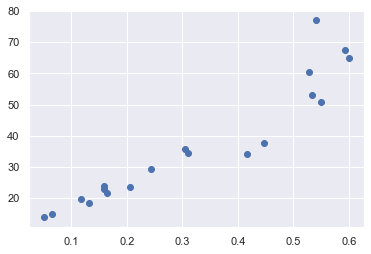

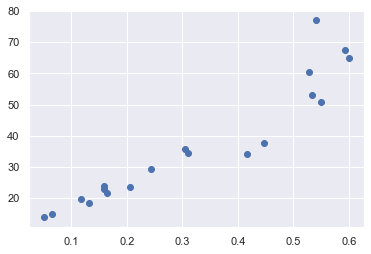

In [140]:
fig = plt.figure()
for idx in range(1):
    plt.scatter(df_param.loc[idx].loc['risk_aversion'][df_param.loc[idx].loc['objective'] < 100],
                df_param.loc[idx].loc['objective'][df_param.loc[idx].loc['objective'] < 100])

fig


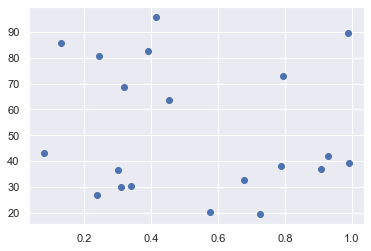

In [148]:
idx = 9

plt.scatter(df_param.loc[idx].loc['risk_aversion'][df_param.loc[idx].loc['objective'] < 100],
                df_param.loc[idx].loc['objective'][df_param.loc[idx].loc['objective'] < 100])

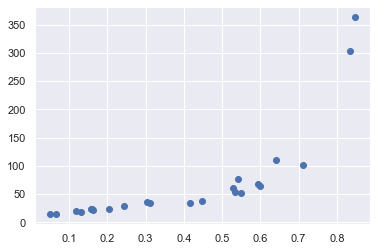

In [131]:
fig = plt.figure()
plt.scatter(df_param.loc[0].loc['risk_aversion'][df_param.loc[0].loc['objective'] < 1000], df_param.loc[0].loc['objective'][df_param.loc[0].loc['objective'] < 1000])


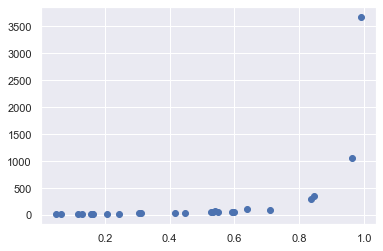

In [124]:
fig

(0, 'A_tilde')
(0, 'B_tilde')
(0, 'a')
(0, 'b')
(0, 'd')
(0, 'objective')
(0, 'risk_aversion')
(1, 'A_tilde')
(1, 'B_tilde')
(1, 'a')
(1, 'b')
(1, 'd')
(1, 'objective')
(1, 'risk_aversion')
(2, 'A_tilde')
(2, 'B_tilde')
(2, 'a')
(2, 'b')
(2, 'd')
(2, 'objective')
(2, 'risk_aversion')
(3, 'A_tilde')
(3, 'B_tilde')
(3, 'a')
(3, 'b')
(3, 'd')
(3, 'objective')
(3, 'risk_aversion')
(4, 'A_tilde')
(4, 'B_tilde')
(4, 'a')
(4, 'b')
(4, 'd')
(4, 'objective')
(4, 'risk_aversion')
(5, 'A_tilde')
(5, 'B_tilde')
(5, 'a')
(5, 'b')
(5, 'd')
(5, 'objective')
(5, 'risk_aversion')
(6, 'A_tilde')
(6, 'B_tilde')
(6, 'a')
(6, 'b')
(6, 'd')
(6, 'objective')
(6, 'risk_aversion')
(7, 'A_tilde')
(7, 'B_tilde')
(7, 'a')
(7, 'b')
(7, 'd')
(7, 'objective')
(7, 'risk_aversion')
(8, 'A_tilde')
(8, 'B_tilde')
(8, 'a')
(8, 'b')
(8, 'd')
(8, 'objective')
(8, 'risk_aversion')
(9, 'A_tilde')
(9, 'B_tilde')
(9, 'a')
(9, 'b')
(9, 'd')
(9, 'objective')
(9, 'risk_aversion')
(10, 'A_tilde')
(10, 'B_tilde')
(10, 'a')
(10, 'b'

In [129]:
df_param.loc[0].loc['objective'][df_param.loc[0].loc['objective'] < 1000]

0      22.985723
1      29.178242
3     109.507410
4      34.205799
5      35.725169
6      64.889986
7      53.141675
8      13.785539
9      37.701947
10     21.571200
11     50.875696
12     18.409638
13     60.345072
14     23.485311
15     14.763382
16     77.241792
17    364.109865
18     23.965986
20     34.376384
21    101.255223
22     67.661669
23     19.576073
24    304.077602
Name: objective, dtype: float64